In [2]:
import torch, re
import torch.utils.data as data_utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def load_data(tokenizer):
    ds = []
    # Read from src
    with open('data/train_set.fasta') as f:
        lines = f.read().split(">")[1:]
        ds = [0]*len(lines)
        for i, line in enumerate(tqdm(lines)):
            seq, sep = line.strip().split("\n")[1:]
            seq = " ".join(seq)
            sep = re.sub("S|T|L|P", "0", sep) # simplify to SP existance
            sep = re.sub("I|M|O",   "1", sep) # simplify to SP non-existance
            sep = 1. if "0" in sep else 0.
            ds[i] = {
                'seq': seq,
                'sep': sep
            }
    # Tokenize data
    ds = [dict(item, **{'tokenized':tokenizer(item['seq'], padding='max_length', max_length=72, return_tensors="pt")}) for item in ds]
    return ds

In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
model = AutoModelForSequenceClassification.from_pretrained("Rostlab/prot_bert", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
ds = load_data(tokenizer)

  0%|          | 0/20290 [00:00<?, ?it/s]

100%|██████████| 20290/20290 [00:00<00:00, 54838.10it/s]


In [7]:
set([d['tokenized']['input_ids'].shape for d in ds])

{torch.Size([1, 72])}

In [8]:
for i in range(len(ds)): 
    ds[i]['tokenized'] = {k: v.flatten().to(device) 
        for k,v in ds[i]['tokenized'].items()}

In [9]:
ds[0]['tokenized']

{'input_ids': tensor([ 2, 21,  6, 16, 15,  5, 19, 18, 12,  5, 19, 10, 12, 13, 15,  7,  5,  7,
          6, 16,  7, 13, 14,  6, 13, 14, 16, 14, 23,  7, 19, 10, 24, 16,  5, 16,
          9, 19, 14, 16, 10, 18, 11, 13,  5, 11,  8, 20, 18, 14, 23,  9, 13, 13,
          7, 13, 17,  8,  5, 19, 14, 10, 10,  8, 12, 13, 13, 17,  9, 14, 11,  3],
        device='cuda:0'),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        device='cuda:0')}

In [10]:
n_neg = len(list(filter(lambda x : x['sep'] == 0, ds)))
n_pos = len(list(filter(lambda x : x['sep'] == 1, ds)))
n_neg, n_pos

(15625, 4665)

In [11]:
neg_weight = (n_neg + n_pos) / n_neg
pos_weight = (n_neg + n_pos) / n_pos
loss_weights = torch.tensor([neg_weight, pos_weight])
loss_weights

tensor([1.2986, 4.3494])

In [12]:
model = model.to(device)
# ds = [dict(item, **{'tokenized':item['tokenized'].to(device)}) for item in ds]

In [24]:
dataset = data_utils.DataLoader(ds, batch_size=16, shuffle=True)
tokens = next(iter(dataset))['tokenized']#.squeeze(1)
tokens['input_ids'].shape

torch.Size([16, 72])

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.functional.mse_loss
epochs = 1

In [26]:
set([d['tokenized']['input_ids'].shape for d in ds])

{torch.Size([72])}

In [28]:
loss_log = []
for epoch in range(epochs):
    for i, batch in enumerate(tqdm(dataset)):
        loss_weights = torch.tensor([neg_weight if x == 0 else pos_weight for x in batch['sep']]).to(device)
        optimizer.zero_grad()
        logits = model.forward(**batch['tokenized']).logits
        y_pred = torch.argmax(logits, dim=1).double().requires_grad_()

        loss = criterion(y_pred, batch['sep'].to(device))
        print(loss, end=" ")
        loss = loss * loss_weights.sum()
        print(loss)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.cpu().detach().item())
        if (i+1) % (len(dataset) // 10) == 0:
            print(np.mean(loss_log))

  0%|          | 1/1269 [00:01<23:40,  1.12s/it]

tensor(0.1875, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(5.6118, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  0%|          | 2/1269 [00:01<18:34,  1.14it/s]

tensor(0.2500, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(8.2451, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  0%|          | 3/1269 [00:02<20:48,  1.01it/s]

tensor(0.1875, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(5.6118, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  0%|          | 4/1269 [00:03<18:24,  1.15it/s]

tensor(0.4375, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(18.4331, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  0%|          | 5/1269 [00:04<20:12,  1.04it/s]

tensor(0.2500, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(8.2451, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  0%|          | 6/1269 [00:05<18:18,  1.15it/s]

tensor(0.1875, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(5.6118, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  1%|          | 7/1269 [00:06<19:59,  1.05it/s]

tensor(0.1250, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(3.3598, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  1%|          | 8/1269 [00:07<18:16,  1.15it/s]

tensor(0.1875, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(5.6118, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  1%|          | 9/1269 [00:08<19:54,  1.06it/s]

tensor(0.6875, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(37.3562, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  1%|          | 10/1269 [00:09<18:14,  1.15it/s]

tensor(0.1875, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(5.6118, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  1%|          | 11/1269 [00:10<19:53,  1.05it/s]

tensor(0.1875, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(5.6118, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  1%|          | 12/1269 [00:10<18:20,  1.14it/s]

tensor(0.1875, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>) tensor(5.6118, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


  1%|          | 12/1269 [00:12<21:03,  1.00s/it]


KeyboardInterrupt: 

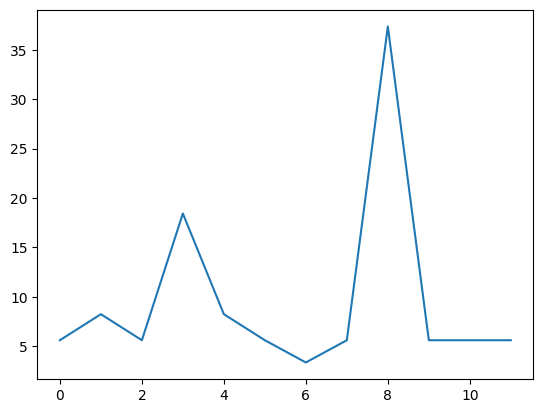

In [35]:
plt.plot(loss_log)

In [37]:
import pickle
with open("log/loss.log", "wb") as file:
    pickle.dump(loss_log, file)
with open("log/loss.log", "rb") as file:
    loss_log = pickle.load(file)

In [ ]:
torch.save(model.state_dict(), "model/model.pth")